<a href="https://colab.research.google.com/github/EstherWhang/jpm_changepoint/blob/main/sp500_get_financial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining a list of equities tickers and the corresponding timeseries

In [1]:
! pip install --quiet yfinance

     |████████████████████████████████| 6.3 MB 4.3 MB/s 


In [2]:
!pip install ruptures

     |████████████████████████████████| 918 kB 3.1 MB/s 


In [3]:
import os
import random
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# this workaround let's us override pandas_datareader with yfinance, 
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()

In [4]:
# Configure filepaths for data storage
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Functions used for finding Breakpoint


In [5]:
def plot_close(df, company_name, start, end):
    df_range = df.loc[(df['Date'] >= start) & (df['Date'] < end)]
    df_range.plot(x='Date',y='Close')
    plt.title(company_name)
    plt.show()

In [60]:
def bin_seg(signal, dates, model, sigma = 5, changepoint_num = 1):
    #model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    algo = rpt.Binseg(model=model).fit(signal)
    bkps = 0
    if changepoint_num != 0: #we know the number of changepoints
      bkps = algo.predict(n_bkps=changepoint_num)
    else: #means we don't know how many changepoints there are
      bkps = algo.predict(epsilon=3 * len(signal) * sigma ** 2)
    # show results
    print("Binary Seg Breaks: "+ str(dates[bkps[:-1]]))
    rpt.show.display(signal, bkps)
    plt.title("Binary Segmentation")
    plt.show()
    return dates[bkps[:-1]]

In [61]:
def bottom_up(signal, dates, model, sigma = 5,changepoint_num = 1):
  #model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    algo = rpt.BottomUp(model=model).fit(signal)
    bkps = 0
    if changepoint_num != 0: #we know the number of changepoints
      bkps = algo.predict(n_bkps=changepoint_num)
    else: #means we don't know how many changepoints there are
      bkps = algo.predict(epsilon=3 * len(signal) * sigma ** 2)
  # show results
    print("Bottom Up Breaks: "+ str(dates[bkps[:-1]]))
    rpt.show.display(signal, bkps)
    plt.title("Bottom-up segmentation")
    plt.show()
    return dates[bkps[:-1]]

In [62]:
def dyn_p(signal, dates, model, changepoint_num = 1): #number of changepoints are known
      # change point detection
    algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(signal)
    bkps = algo.predict(n_bkps=changepoint_num )
    print("Dynamic Programming: "+ str(dates[bkps[:-1]]))
# show results
    rpt.show.display(signal, bkps)
    plt.title("Dynamic Programming")
    plt.show()
    return dates[bkps[:-1]]

In [63]:
#models : "l2" linear, "rbf" gaussian
#Linearly penalized segmentation
#https://github.com/deepcharles/ruptures/blob/master/docs/examples/kernel-cpd-performance-comparison.ipynb
def pelt(signal, dates, model, jump=1, min_size=2,beta=100 ): 
  #alternative to dynamic, when you don't know number of changepoints
    algo = rpt.Pelt(model=model, jump=jump, min_size=min_size).fit(signal)
    bkps = algo.predict(pen=beta)
    
    print("PELT: "+ str(dates[bkps[:-1]]))
    rpt.show.display(signal, bkps)
    plt.title("Linearly penalized segmentation")
    plt.show()
    return dates[bkps[:-1]]

In [64]:
def window(signal, dates, model, sigma = 5, changepoint_num = 1):
    algo = rpt.Window(width=10, model=model).fit(signal)
    bkps = 0
    if changepoint_num != 0: #we know the number of changepoints
      bkps = algo.predict(n_bkps=changepoint_num)
    else: #means we don't know how many changepoints there are
      bkps = algo.predict(epsilon=3 * len(signal) * sigma ** 2)
    # show results
    print("Window Breaks: "+ str(dates[bkps[:-1]]))
    rpt.show.display(signal, bkps)
    plt.title("Window-based change point detection")
    plt.show()
    return dates[bkps[:-1]]

## Get list of companies in SP500

We will obtain and store the list of the constituents from Wikipedia.

In [11]:
today = datetime.today().strftime('%Y-%m-%d')
print(today)

data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks')

table   = data[0]
print(table.columns)
symbols = list(table.Symbol.values)
symb_sectors = table.loc[:,['Symbol','GICS Sector']]
sectors = list((table.loc[:,'GICS Sector']).drop_duplicates())
print(sectors)
df = pd.DataFrame(symb_sectors, columns=['Symbol', 'GICS Sector'])
print(df.head())
print("{} symbols in total".format(len(df)))

2021-11-17
Index(['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded'],
      dtype='object')
['Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Discretionary', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Consumer Staples', 'Energy']
  Symbol             GICS Sector
0    MMM             Industrials
1    ABT             Health Care
2   ABBV             Health Care
3   ABMD             Health Care
4    ACN  Information Technology
505 symbols in total


In [12]:
#sort stocks into sectors
df_grouped_sectors = df.groupby('GICS Sector')

print((df_grouped_sectors.get_group(sectors[0]))["Symbol"])

#i can get group 

0       MMM
14      ALK
18     ALLE
27      AAL
35      AME
       ... 
464     URI
469    VRSK
479     WAB
483      WM
499     XYL
Name: Symbol, Length: 74, dtype: object


## Download price timeseries

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

downloading data for the first 2 quarters of 2020 for certain sector (financial for this example)

In [13]:
start_date = '2020-01-01'
end_date  = '2020-06-30'

symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.get_data_yahoo(symbol, start_date, end_date)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [14]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()

History for CTXS


,Adj Close,Volume
Date,,
2020-01-02,109.427856,1352600
2020-01-03,109.574844,1107000
2020-01-06,110.740959,1046700
2020-01-07,110.153000,933700
2020-01-08,111.475906,1261600


## Pre-process Financial Timeseries

> changed so it gets information by sector



In [15]:
print(list(df_grouped_sectors.get_group('Financials')["Symbol"]))

['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG', 'AIZ', 'BAC', 'BRK.B', 'BLK', 'BK', 'BRO', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CMA', 'DFS', 'RE', 'FITB', 'FRC', 'BEN', 'GL', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JPM', 'KEY', 'LNC', 'L', 'MTB', 'MKTX', 'MMC', 'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PBCT', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'SIVB', 'SYF', 'TROW', 'TRV', 'TFC', 'USB', 'WRB', 'WFC', 'WLTW', 'ZION']


In [16]:
def normalize(df, columns, valid_dates):
    #normalize
  scaler = MinMaxScaler()

  #all stocks
  scaler.fit(df)
  scaled = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled, columns=columns)
  scaled_df.insert(0, 'Date', valid_dates)
  scaled_df.set_index('Date', inplace=True)
  return scaled_df

In [17]:
def clean_up_data(df_price, df_volume):
  df_price.dropna(how='all', inplace=True)
  df_volume.dropna(how='all', inplace=True)
  assert((df_price.index == df_volume.index).all())


  return df_price, df_volume, df_price.index

In [18]:
def price_volume_by_sector(df_grouped_sectors, sector, start_date = '2020-01-01', end_date  = '2020-06-30'):
  sector_symbols = list(df_grouped_sectors.get_group(sector)["Symbol"])
    # initialize an empty DateTime Index
  index = pd.date_range(start=start_date, end=end_date, freq='D')
  df_sector_price = pd.DataFrame(index=index, columns=sector_symbols)               # initialize empty dataframes
  df_sector_volume = pd.DataFrame(index=index, columns=sector_symbols)

  for symbol in sector_symbols:
    sector_symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    sector_symbol_df.index = pd.to_datetime(sector_symbol_df.index)
    df_sector_price[symbol] = sector_symbol_df['Adj Close']
    df_sector_volume[symbol] = sector_symbol_df['Volume']
  return df_sector_price, df_sector_volume

In [19]:
# Aggregate all symbols into a price dataframe and volume dataframe
# edited so it gets data by sector
#example is financial sector

#MAKE CODE MORE EFFICIENT LATER: FOR NOW GET THINGS WORKING

sector_symbols = list(df_grouped_sectors.get_group( 'Financials')["Symbol"])
df_sector_price, df_sector_volume = price_volume_by_sector(df_grouped_sectors, 'Financials',start_date = '2020-01-01', end_date  = '2020-06-30')

In [20]:
df_sector_price, df_sector_volume, valid_dates =clean_up_data(df_sector_price, df_sector_volume)
df_sector_price_normed = normalize(df_sector_price, sector_symbols, valid_dates)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [21]:
df_sector_price_normed.to_csv(os.path.join(data_dir, "sector_prices.csv"))
df_sector_volume.to_csv(os.path.join(data_dir, "sector_volume.csv"))

In [22]:
df_sector_price_normed.head()

,AFL,ALL,AXP,AIG,AMP,AON,AJG,AIZ,BAC,BRK.B,BLK,BK,BRO,COF,CBOE,SCHW,CB,CINF,C,CFG,CME,CMA,DFS,RE,FITB,FRC,BEN,GL,GS,HIG,HBAN,ICE,IVZ,JPM,KEY,LNC,L,MTB,MKTX,MMC,MET,MCO,MS,MSCI,NDAQ,NTRS,PBCT,PNC,PFG,PGR,PRU,RJF,RF,SPGI,STT,SIVB,SYF,TROW,TRV,TFC,USB,WRB,WFC,WLTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.997501,0.754706,0.836987,0.923561,0.882188,0.683977,0.664038,0.835467,1.000000,NaN,0.738227,0.976478,0.467429,0.951031,0.838518,0.962370,0.867788,0.860475,0.985308,0.995274,0.739285,1.000000,0.990902,0.894329,1.000000,0.938476,0.936422,0.894359,0.864823,0.992242,1.000000,0.773262,0.924609,1.000000,1.000000,0.958627,0.894348,0.976622,0.408749,0.816390,0.954841,0.636384,0.814686,0.332687,0.711184,0.961328,1.000000,0.994470,0.958624,0.316096,0.960643,0.772964,1.000000,0.599446,0.945605,0.881840,0.991077,0.736711,0.935206,1.000000,1.000000,0.708108,1.000000,0.782345,1.000000
2020-01-03,0.984294,0.754898,0.818596,0.912278,0.860518,0.675077,0.659116,0.845669,0.957580,NaN,0.715924,0.949176,0.469799,0.926002,0.873272,0.902749,0.864379,0.868620,0.952252,0.962192,0.771605,0.975899,0.967412,0.887274,0.970026,0.931591,0.889192,0.870590,0.840772,0.983336,0.977602,0.833726,0.897803,0.969751,0.970850,0.918547,0.886933,0.955854,0.407919,0.812430,0.936689,0.631379,0.786228,0.289617,0.720636,0.913846,0.980396,0.975114,0.933491,0.315535,0.933128,0.739168,0.966842,0.592915,0.915638,0.853659,0.968983,0.728945,0.926916,0.984723,0.977205,0.710606,0.989186,0.783034,0.973742
2020-01-06,0.978940,0.761247,0.810652,0.913406,0.866167,0.681590,0.669945,0.847612,0.954714,NaN,0.717697,0.968918,0.468021,0.911700,0.851383,0.918876,0.882557,0.856251,0.946851,0.953922,0.781660,0.953124,0.942930,0.882234,0.957106,0.899386,0.907357,0.860215,0.861575,0.978739,0.947737,0.834633,0.907855,0.967953,0.945864,0.907514,0.861725,0.939239,0.383131,0.813129,0.931895,0.637635,0.780130,0.300181,0.719197,0.911053,0.969192,0.971092,0.936250,0.391103,0.937134,0.731369,0.947155,0.607875,0.946361,0.845862,0.968558,0.743530,0.929454,0.969447,0.950776,0.707831,0.978700,0.786483,0.951387
2020-01-07,0.961093,0.742586,0.801089,0.905226,0.845420,0.662379,0.644594,0.833037,0.941530,NaN,0.730971,0.990339,0.460913,0.896154,0.813556,0.932560,0.837965,0.826235,0.931944,0.944076,0.776872,0.942953,0.927876,0.863473,0.939535,0.886059,0.931880,0.858328,0.875093,0.963223,0.927827,0.826470,0.905342,0.929529,0.933370,0.921925,0.852828,0.915149,0.387989,0.805210,0.943539,0.630378,0.776742,0.303107,0.682419,0.923514,0.949587,0.955381,0.946977,0.358752,0.935392,0.751733,0.923322,0.621501,0.974565,0.854159,0.947313,0.753001,0.895449,0.961646,0.932606,0.672871,0.964282,0.780690,0.940387
2020-01-08,0.966804,0.748550,0.832426,0.922150,0.860723,0.671604,0.647794,0.841135,0.961593,NaN,0.730477,0.992859,0.478092,0.912632,0.790323,0.946732,0.823053,0.817335,0.944907,0.956285,0.790159,0.954229,0.942433,0.857038,0.943152,0.896498,0.919164,0.857385,0.895018,0.972417,0.942759,0.801378,0.910368,0.946861,0.949195,0.942190,0.853199,0.925117,0.342524,0.797523,0.962033,0.668916,0.798763,0.336831,0.670297,0.944355,0.963591,0.975868,0.954333,0.383593,0.945841,0.789645,0.933684,0.649806,0.963989,0.871182,0.958785,0.775731,0.919980,0.965546,0.928642,0.686189,0.969525,0.783862,0.958129


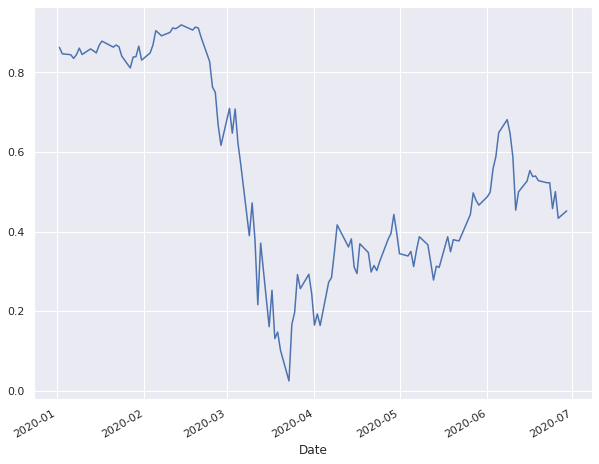

In [23]:
df_sector_price_normed.mean(axis=1).plot()

Looking at changepoint by the averages of each sector

In [24]:
#to plot the mean of all sectors: 
index = pd.date_range(start=start_date, end=end_date, freq='D')
df_mean_price = pd.DataFrame(index=index, columns=sectors)               # initialize empty dataframes
df_mean_volume = pd.DataFrame(index=index, columns=sectors)
for sector in sectors:
  df_sector_price, df_sector_volume = price_volume_by_sector(df_grouped_sectors, sector)
  df_mean_price[sector] = df_sector_price.mean(axis=1)
  df_mean_volume[sector] = df_sector_volume.mean(axis=1)


In [25]:
df_mean_price, df_mean_volume, valid_dates = clean_up_data(df_mean_price, df_mean_volume)
print(df_mean_price.head())
df_mean_price_normed = normalize(df_mean_price, sectors, valid_dates)
print(df_mean_price_normed.head())

            Industrials  Health Care  ...  Consumer Staples     Energy
2020-01-02   134.582917   169.382349  ...         87.987350  55.302617
2020-01-03   134.737308   167.762865  ...         88.280972  55.207900
2020-01-06   134.669807   169.270665  ...         88.496165  55.815884
2020-01-07   134.698714   169.394026  ...         87.795399  56.155783
2020-01-08   135.073697   170.641165  ...         88.325112  54.975180

[5 rows x 11 columns]
            Industrials  Health Care  ...  Consumer Staples    Energy
Date                                  ...                            
2020-01-02     0.909126     0.733737  ...          0.809273  0.976707
2020-01-03     0.911750     0.707142  ...          0.822437  0.974121
2020-01-06     0.910603     0.731902  ...          0.832085  0.990720
2020-01-07     0.911094     0.733928  ...          0.800666  1.000000
2020-01-08     0.917465     0.754408  ...          0.824416  0.967767

[5 rows x 11 columns]


In [26]:
df_mean_price_normed.to_csv(os.path.join(data_dir, "mean_prices.csv"))
df_mean_volume.to_csv(os.path.join(data_dir, "mean_volume.csv"))


Text(0.5, 1.0, 'Volume by Sector')

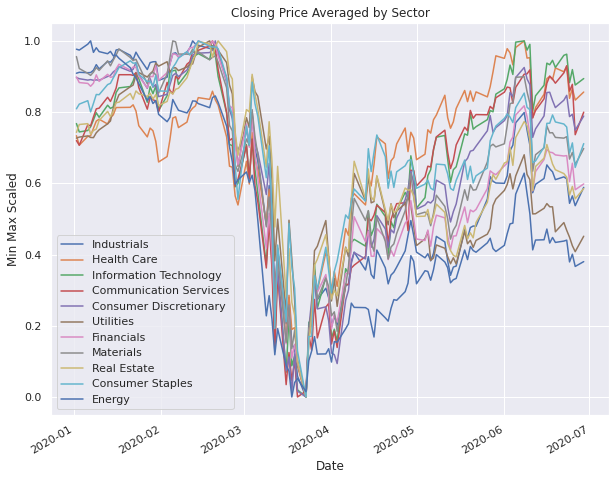

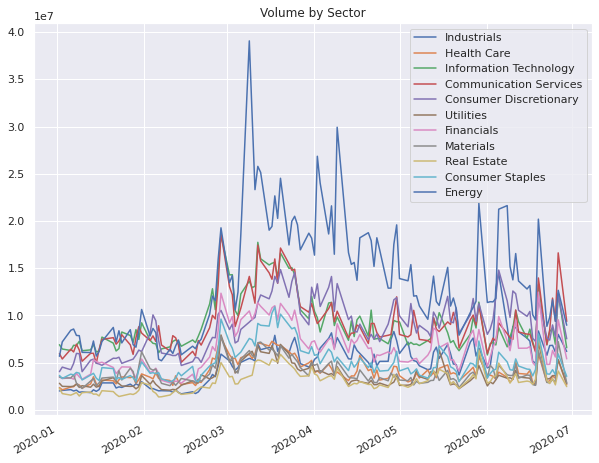

In [27]:
df_mean_price_normed.plot()
plt.title("Closing Price Averaged by Sector")
plt.ylabel("Min Max Normed")
df_mean_volume.plot()
plt.title("Volume by Sector")


In [28]:
df_mean_price_normed["Financials"].head()

Date
2020-01-02    0.898825
2020-01-03    0.882984
2020-01-06    0.880629
2020-01-07    0.872623
2020-01-08    0.881149
Name: Financials, dtype: float64

In [29]:
import ruptures as rpt

change points

In [59]:
def breakpoints_by_sector(index, signal, sector,model,sigma = 5,changepoint_num=1):
  signal = np.array(signal)
  dates = np.array(index)
  print("-----------------------------------------------")
  print(sector)
  bkps_sector = np.array([]
  #known change point
  if changepoint_num > 0:
    print("---------------Known Break Point---------------")
    binseg_bkps = bin_seg(signal, dates, model,changepoint_num = changepoint_num)
    bottom_up_bkps = bottom_up(signal, dates, model,changepoint_num = changepoint_num)
    dyn_p_bkps = dyn_p(signal, dates, model,changepoint_num = changepoint_num)
    window__bkps = window(signal, dates, model,changepoint_num = changepoint_num)
    np.append([binseg_bkps, binseg_bkps,dyn_p_bkps,window__bkps])
  else:

    print("-----------------------------------------------")
    print("--------------Unknown Break Point--------------")
  #note: since there is no artificial breakpoint, color change is the rupture's prediction
    binseg_bkps=bin_seg(signal, dates, model,sigma = sigma, changepoint_num = 0)
    bottom_up_bkps=bottom_up(signal, dates, model, sigma = sigma, changepoint_num = 0)
    pelt_bkps = pelt(signal, dates, model) 
    window__bkps = window(signal, dates, model,sigma = sigma,  changepoint_num = 0)
    bkps_sector.append([binseg_bkps, binseg_bkps,pelt_bkps,window__bkps])
  return bkps_sector

-----------------------------------------------
Financials
---------------Known Break Point---------------
Binary Seg Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-05T00:00:00.000000000']


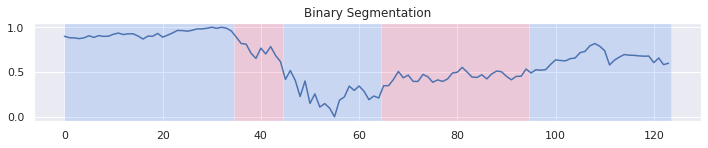

Bottom Up Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-10T00:00:00.000000000']


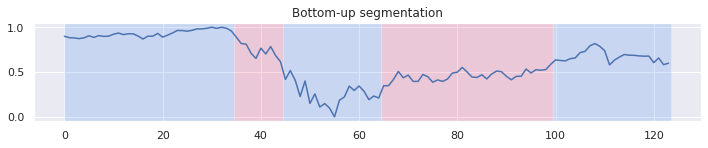

Dynamic Programming: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-10T00:00:00.000000000']


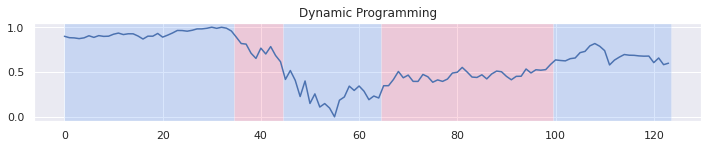

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-15T00:00:00.000000000']


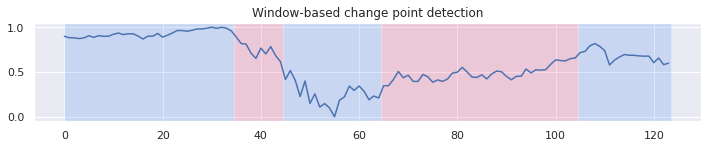

In [78]:
model = "l2"

#pick one breakpoint, 11 sectors, that'll get 11 dates, create a slide with assumed 1 breakpoint and compare
#then talk about the best changepoint

#just known
sector = "Financials"
signal = df_mean_price_normed[sector]
bkps_sector = breakpoints_by_sector(index, signal, sector, model, changepoint_num=4) #play around for best results
#annotate and create narrative with wikipedia dates
detectors = ["Bin Seg", "Bottom-Up", "Dynamic Prog", "Window"]
bkps = np.squeeze(bkps_sector)

# creating df object with columns specified    


In [79]:
breakpoints_sector= pd.DataFrame(np.transpose(bkps), columns =detectors) 
breakpoints_sector #add the dates for the rupture plots

,Bin Seg,Bottom-Up,Dynamic Prog,Window
0,2020-02-05,2020-02-05,2020-02-05,2020-02-05
1,2020-02-15,2020-02-15,2020-02-15,2020-02-15
2,2020-03-06,2020-03-06,2020-03-06,2020-03-06
3,2020-04-05,2020-04-05,2020-04-10,2020-04-15


-----------------------------------------------
Industrials
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000']


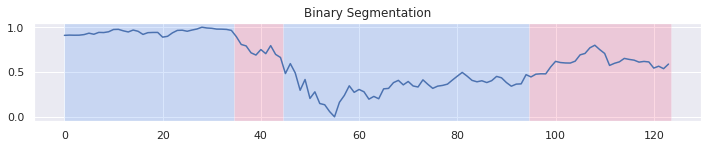

Bottom Up Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000']


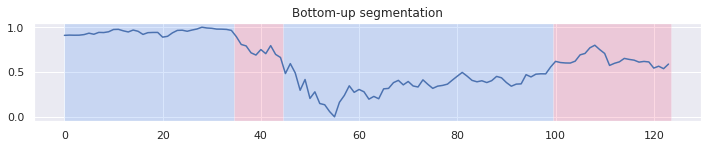

PELT: []


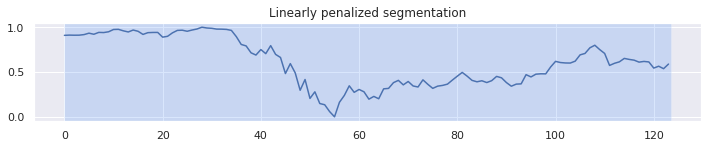

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-21T00:00:00.000000000'
 '2020-04-15T00:00:00.000000000']


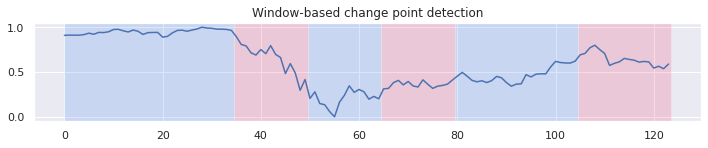

-----------------------------------------------
Health Care
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-15T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-26T00:00:00.000000000']


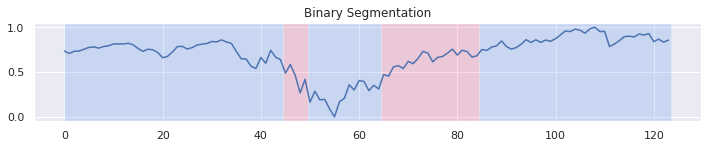

Bottom Up Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-11T00:00:00.000000000' '2020-03-26T00:00:00.000000000']


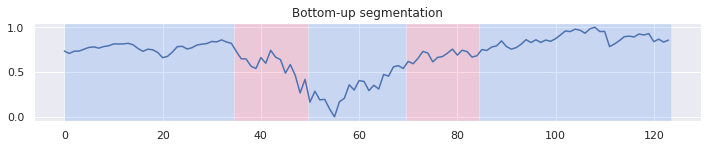

PELT: []


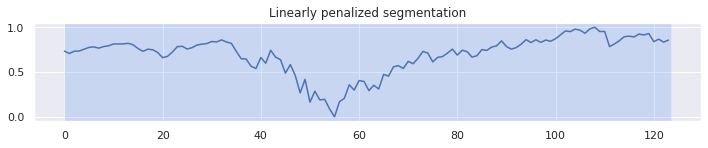

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-26T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000' '2020-04-20T00:00:00.000000000']


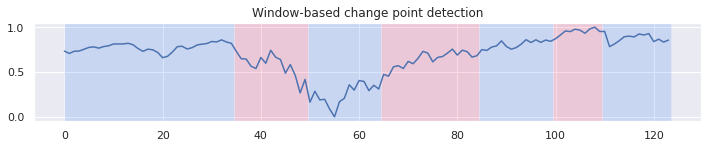

-----------------------------------------------
Information Technology
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-26T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000']


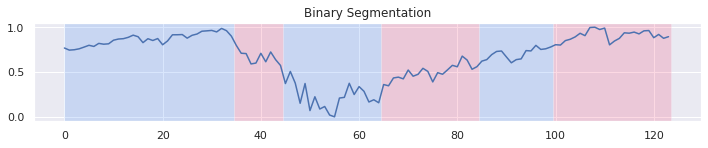

Bottom Up Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-05T00:00:00.000000000']


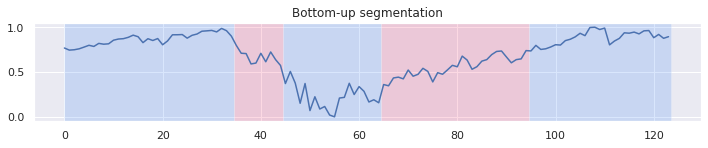

PELT: []


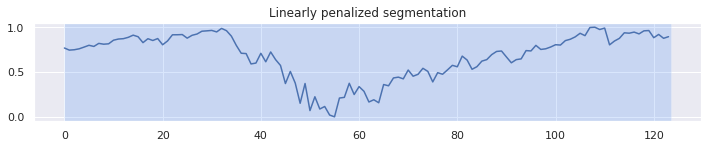

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-21T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000' '2020-04-15T00:00:00.000000000']


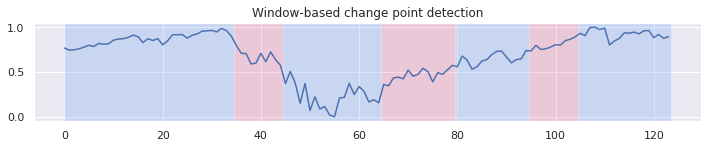

-----------------------------------------------
Communication Services
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-11T00:00:00.000000000' '2020-03-26T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000']


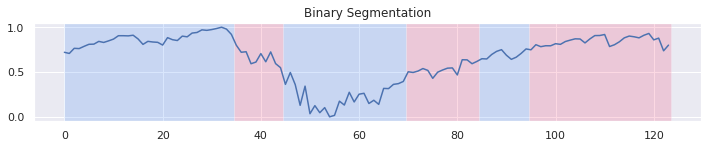

Bottom Up Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-26T00:00:00.000000000']


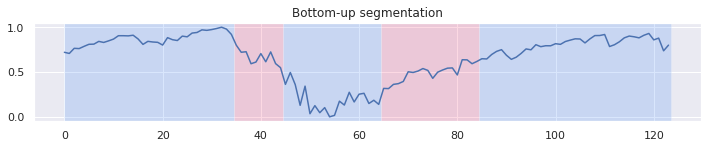

PELT: []


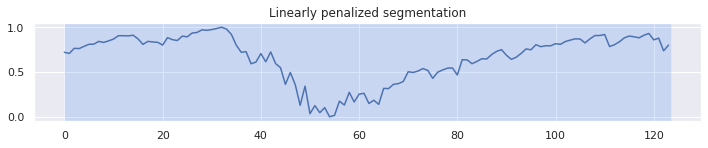

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-11T00:00:00.000000000' '2020-03-26T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000']


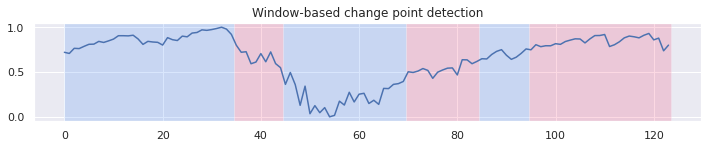

-----------------------------------------------
Consumer Discretionary
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-15T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-21T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000']


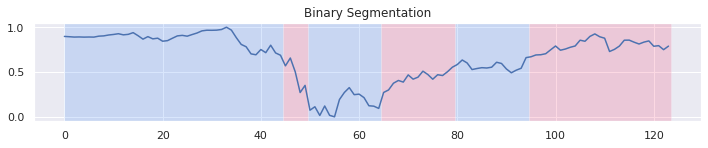

Bottom Up Breaks: ['2020-02-15T00:00:00.000000000' '2020-03-06T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000']


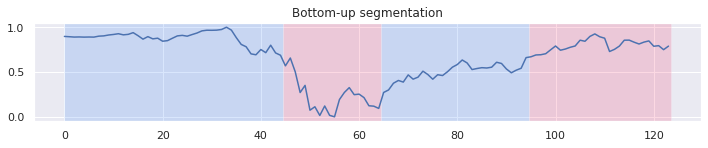

PELT: []


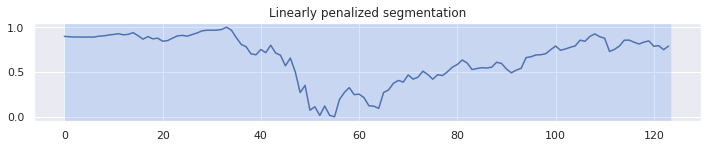

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-05T00:00:00.000000000'
 '2020-04-15T00:00:00.000000000']


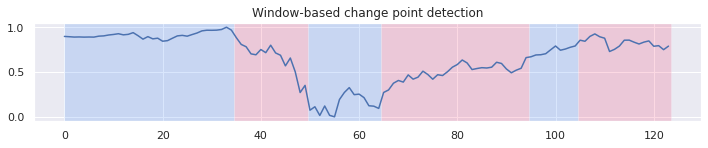

-----------------------------------------------
Utilities
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-01-11T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-02-20T00:00:00.000000000' '2020-03-06T00:00:00.000000000']


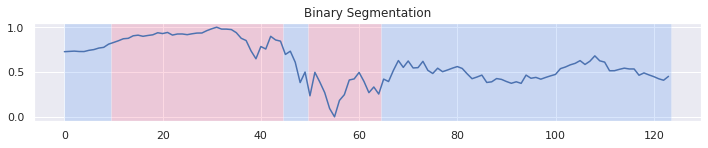

Bottom Up Breaks: ['2020-02-15T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000']


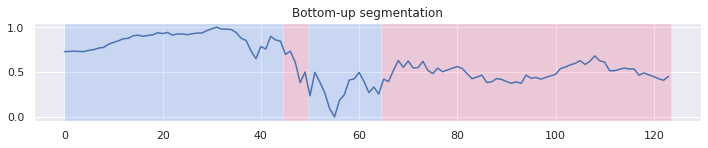

PELT: []


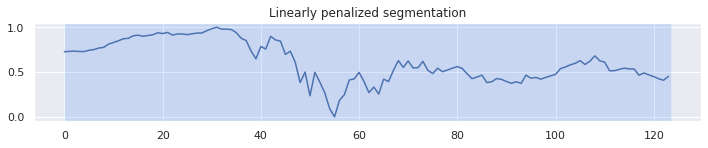

Window Breaks: ['2020-01-11T00:00:00.000000000' '2020-02-05T00:00:00.000000000'
 '2020-02-20T00:00:00.000000000' '2020-03-06T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000' '2020-04-20T00:00:00.000000000']


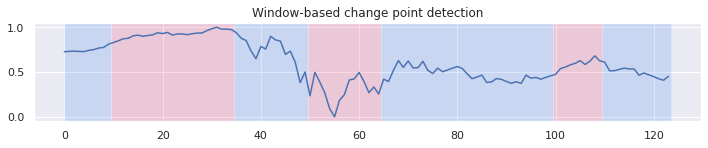

-----------------------------------------------
Financials
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-05T00:00:00.000000000']


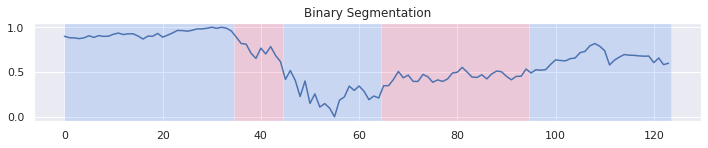

Bottom Up Breaks: ['2020-02-15T00:00:00.000000000' '2020-04-10T00:00:00.000000000']


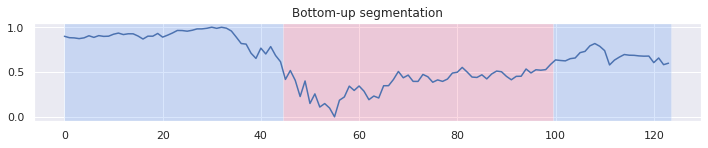

PELT: []


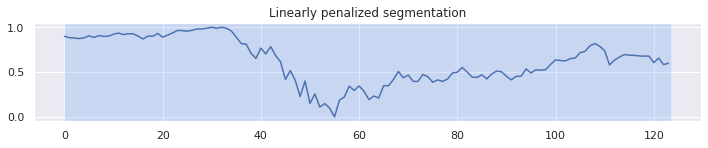

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-15T00:00:00.000000000']


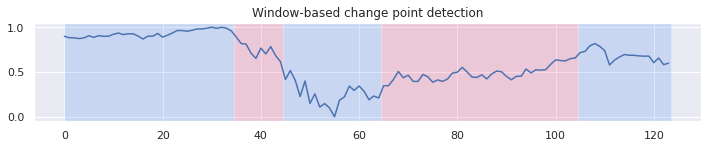

-----------------------------------------------
Materials
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-05T00:00:00.000000000']


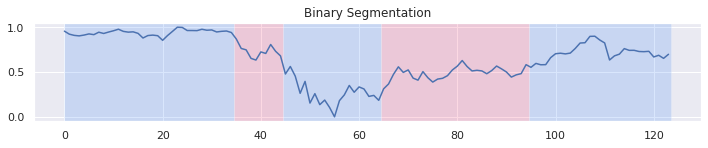

Bottom Up Breaks: ['2020-02-15T00:00:00.000000000' '2020-03-06T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000']


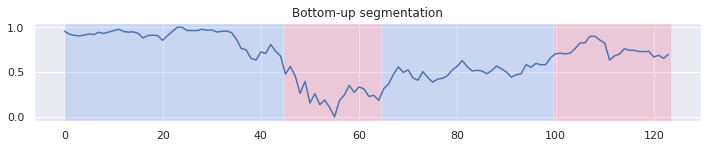

PELT: []


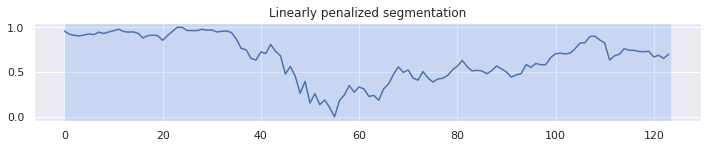

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-03-21T00:00:00.000000000'
 '2020-04-15T00:00:00.000000000']


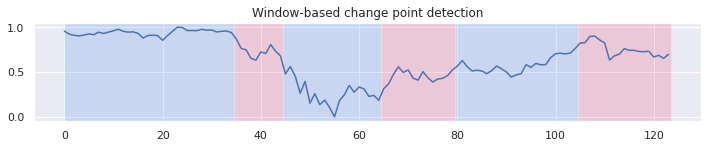

-----------------------------------------------
Real Estate
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-15T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-10T00:00:00.000000000']


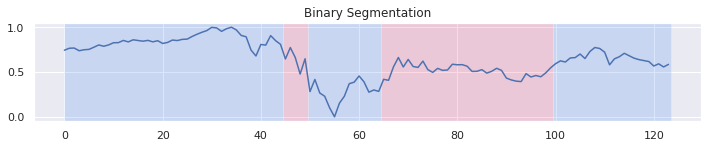

Bottom Up Breaks: ['2020-02-20T00:00:00.000000000' '2020-03-06T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000']


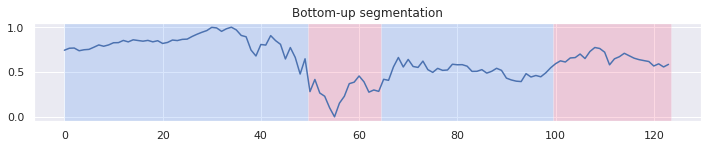

PELT: []


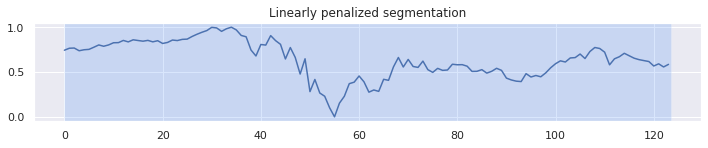

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-10T00:00:00.000000000']


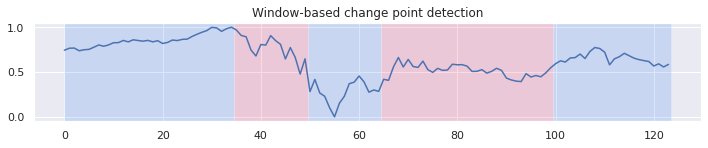

-----------------------------------------------
Consumer Staples
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-15T00:00:00.000000000' '2020-02-20T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-10T00:00:00.000000000']


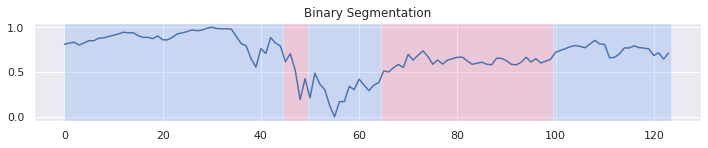

Bottom Up Breaks: ['2020-02-15T00:00:00.000000000' '2020-03-06T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000']


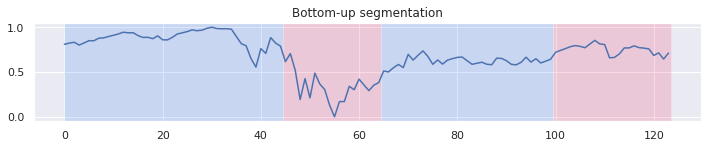

PELT: []


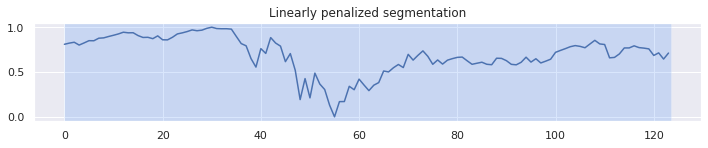

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-10T00:00:00.000000000']


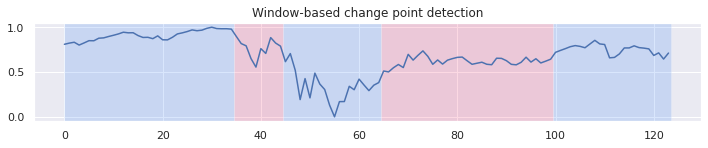

-----------------------------------------------
Energy
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-21T00:00:00.000000000']


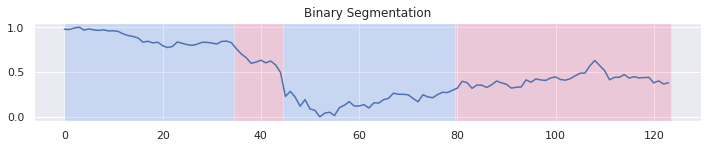

Bottom Up Breaks: ['2020-02-15T00:00:00.000000000' '2020-03-21T00:00:00.000000000']


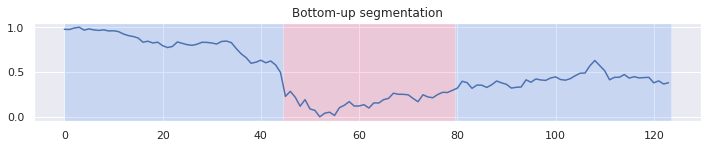

PELT: []


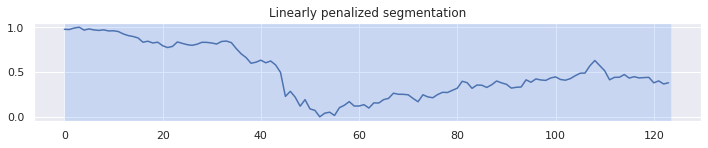

Window Breaks: ['2020-02-05T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-03-06T00:00:00.000000000' '2020-04-15T00:00:00.000000000']


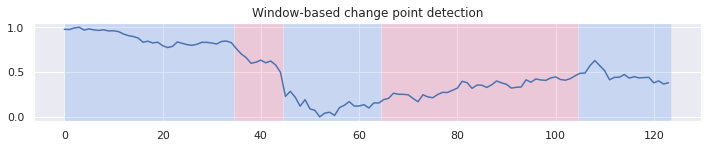

In [84]:
model = "l2"
#unknown number of breakpoints
#compare changepoint dates by sector
#more of a case study (more change, more stable, similar?)
total_bkps = []
for sector in sectors:
  signal = df_mean_price_normed[sector]
  bkps_sector = breakpoints_by_sector(index, signal, sector, model,  sigma = 0.05, changepoint_num=0)